# Base BERT implementation

1. Import dependencies

In [1]:
import random
import time

import numpy as np
import torch
import os

from transformers import (
    AutoTokenizer,
    DataCollatorForTokenClassification,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)

from tokenizers import pre_tokenizers
import sys

sys.path.append('..')
from src.util.torch_device import resolve_torch_device
from src.data.span_detection_ds import ManipulationDetectionDataset
from src.visualization.plot import plot_loss, plot_model_progress, plot_eval_loss
from src.definitions import (
    MODELS_FOLDER,
    RAW_DATA_FOLDER,
    REPORTS_FOLDER,
    PROCESSED_DATA_FOLDER,
)
from src.visualization.ner import visualize_as_markdown_and_save
from src.visualization.reporting import EvaluatingReport
from src.model.span_detection_metrics import compute_metrics

2. Prepare Env

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

model_checkpoint = 'EvanD/xlm-roberta-base-ukrainian-ner-ukrner'#'dardem/xlm-roberta-large-uk-toxicity'#'ukr-models/uk-ner'#'google-bert/bert-base-multilingual-cased'#YaraKyrychenko/ukraine-war-pov#'youscan/ukr-roberta-base'#"distilbert/distilbert-base-multilingual-cased"

epoch_time = int(time.time())

#os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

3. Load dataset

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, model_max_length=512)

dataset_blueprint = ManipulationDetectionDataset(
    tokenizer=tokenizer,
    raw_path=RAW_DATA_FOLDER / "span-detection.parquet",
    processed_path=PROCESSED_DATA_FOLDER / "span-detection",
    seed=random_seed,
)

dataset = dataset_blueprint.read()
dataset

Map:   0%|          | 0/3439 [00:00<?, ? examples/s]

Map:   0%|          | 0/383 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3439 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/383 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'content', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3439
    })
    test: Dataset({
        features: ['id', 'content', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 383
    })
})

3. Prepare model

In [4]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(dataset_blueprint.label2id),
    id2label=dataset_blueprint.id2label,
    label2id=dataset_blueprint.label2id,
    #dropout=0.2,
    #hidden_dropout_prob=0.2,
    #attention_probs_dropout_prob=0.2,
    ignore_mismatched_sizes=True
).to(device)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at EvanD/xlm-roberta-base-ukrainian-ner-ukrner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
for name, layer in model.named_parameters():
    if 'classifier' not in name:
        layer.requires_grad = False

In [6]:
for name, layer in model.named_parameters():
    print(name, layer.requires_grad)

roberta.embeddings.word_embeddings.weight False
roberta.embeddings.position_embeddings.weight False
roberta.embeddings.token_type_embeddings.weight False
roberta.embeddings.LayerNorm.weight False
roberta.embeddings.LayerNorm.bias False
roberta.encoder.layer.0.attention.self.query.weight False
roberta.encoder.layer.0.attention.self.query.bias False
roberta.encoder.layer.0.attention.self.key.weight False
roberta.encoder.layer.0.attention.self.key.bias False
roberta.encoder.layer.0.attention.self.value.weight False
roberta.encoder.layer.0.attention.self.value.bias False
roberta.encoder.layer.0.attention.output.dense.weight False
roberta.encoder.layer.0.attention.output.dense.bias False
roberta.encoder.layer.0.attention.output.LayerNorm.weight False
roberta.encoder.layer.0.attention.output.LayerNorm.bias False
roberta.encoder.layer.0.intermediate.dense.weight False
roberta.encoder.layer.0.intermediate.dense.bias False
roberta.encoder.layer.0.output.dense.weight False
roberta.encoder.layer.

In [7]:
data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir=MODELS_FOLDER / "manipulation-detector-bert-ner-checkpoint",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
#    load_best_model_at_end=True,
    seed=random_seed,
    logging_strategy="epoch",
    run_name=f"EvanD/xlm-roberta-base-ukrainian-ner-ukrner",
    #warmup_steps=80,
#    auto_find_batch_size=True,
#    torch_empty_cache_steps=1000,
#    metric_for_best_model="token_f1",
#    greater_is_better=True, 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics(dataset_blueprint),
)

4. Train model

In [ ]:
trainer.train()

In [46]:
for name, layer in model.named_parameters():
    layer.requires_grad = True

In [49]:
trainer.train()

Epoch,Training Loss,Validation Loss,Token F1,Token Precision,Token Recall,Token Accuracy,Span F1,Span Precision,Span Recall,Span Accuracy
1,0.476400,0.406173,0.613614,0.640413,0.588968,0.800597,0.077864,0.063177,0.101449,0.800597
2,0.409800,0.406233,0.601549,0.676638,0.541461,0.807165,0.098013,0.090244,0.107246,0.807165
3,0.361500,0.435576,0.549356,0.693175,0.454961,0.799337,0.118149,0.116084,0.120290,0.799337
4,0.318500,0.427701,0.615365,0.645275,0.588105,0.802355,0.122148,0.113750,0.131884,0.802355


TrainOutput(global_step=860, training_loss=0.3915583677070085, metrics={'train_runtime': 1325.2422, 'train_samples_per_second': 10.38, 'train_steps_per_second': 0.649, 'total_flos': 3062030030036532.0, 'train_loss': 0.3915583677070085, 'epoch': 4.0})

In [5]:
trainer.train()

Epoch,Training Loss,Validation Loss,Token F1,Token Precision,Token Recall,Span F1,Span Precision,Span Recall
1,0.483200,0.434898,0.350556,0.743006,0.229393,0.055257,0.058728,0.052174
2,0.420900,0.426085,0.467786,0.724566,0.345385,0.082317,0.086817,0.078261
3,0.375000,0.398884,0.584800,0.673857,0.516535,0.103064,0.099196,0.107246
4,0.333100,0.434658,0.621020,0.643055,0.600444,0.133146,0.128901,0.137681
5,0.301400,0.448960,0.599055,0.660959,0.547754,0.125445,0.123422,0.127536


TrainOutput(global_step=1075, training_loss=0.38271137326262716, metrics={'train_runtime': 452.4767, 'train_samples_per_second': 38.002, 'train_steps_per_second': 2.376, 'total_flos': 3837166858893876.0, 'train_loss': 0.38271137326262716, 'epoch': 5.0})

In [9]:
evaluation_feedback = trainer.evaluate()

In [10]:
from pathlib import Path
import csv
import pandas as pd

class EvaluatingReport_new:

    __report_columns = [
        "timestamp",
        "eval_loss",
        "eval_token_precision",
        "eval_token_recall",
        "eval_token_f1",
        "eval_span_precision",
        "eval_span_recall",
        "eval_span_f1",
        "eval_runtime",
        "eval_samples_per_second",
        "eval_steps_per_second",
        "epoch",
    ]

    __path: Path

    def __init__(self, path):
        self.__path = path

    def write_to_report(self, output, now):
        os.makedirs(os.path.dirname(self.__path), exist_ok=True)

        row = [now] + [output[col] for col in self.__report_columns[1:]]

        with open(self.__path, "a") as the_file:
            writer = csv.writer(the_file)
            writer.writerow(row)

    def read_report(self):
        return pd.read_csv(
            self.__path,
            names=self.__report_columns,
        )

In [11]:
report_file = REPORTS_FOLDER / "span-detection" / "train-report.csv"

report = EvaluatingReport_new(report_file)

report.write_to_report(evaluation_feedback, epoch_time)

full_report = report.read_report()

full_report.tail(1)

,timestamp,eval_loss,eval_token_precision,eval_token_recall,eval_token_f1,eval_span_precision,eval_span_recall,eval_span_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
24,1739990554,0.434658,0.643055,0.600444,0.62102,0.128901,0.137681,0.133146,6.0635,63.165,3.958,5.0


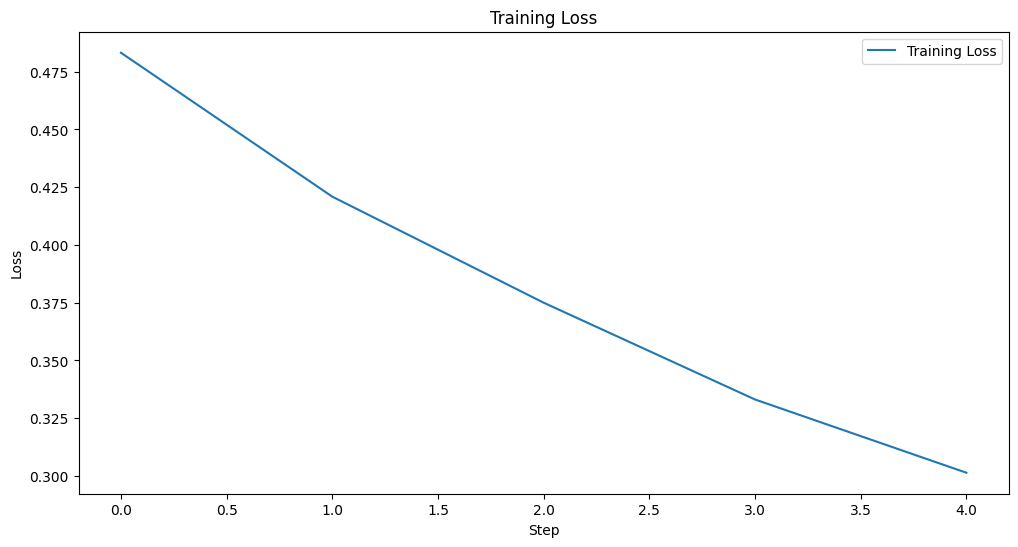

In [12]:
plot_loss(trainer)

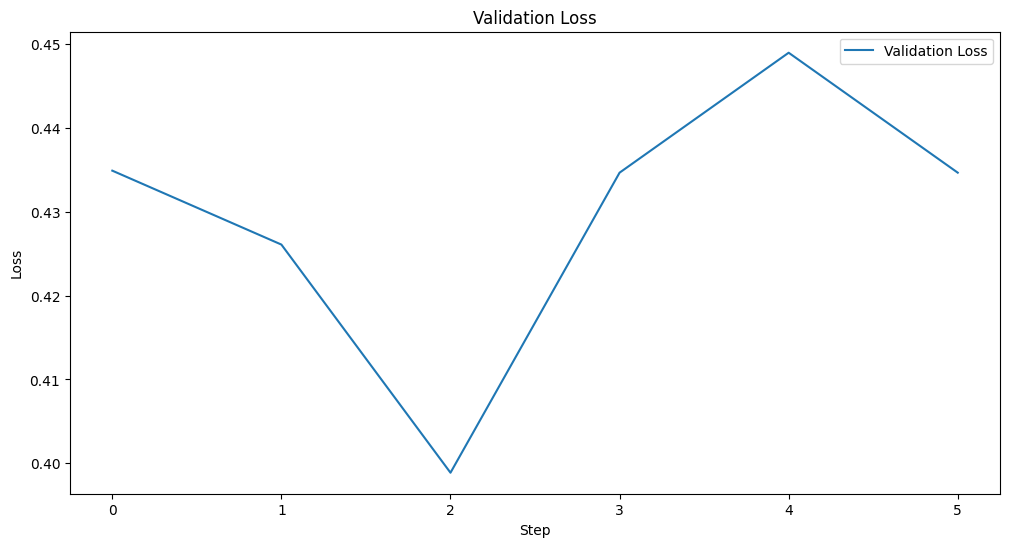

In [13]:
plot_eval_loss(trainer)

In [ ]:
plot_model_progress(full_report) # not working

5. Save weights

In [16]:
trainer.save_model(MODELS_FOLDER / "manipulation-detector-xlm-roberta-base-ukrainian-ner-ukrner_exclude_tail_2e-5_5epochs")
tokenizer.save_pretrained(MODELS_FOLDER / "manipulation-detector-xlm-roberta-base-ukrainian-ner-ukrner_exclude_tail_2e-5_5epochs")

('c:\\Users\\Vitalii\\Desktop\\5_course\\UNLP\\unlp-2025-manipulation-detector\\notebooks\\..\\models\\manipulation-detector-xlm-roberta-base-ukrainian-ner-ukrner_exclude_tail_2e-5_5epochs\\tokenizer_config.json',
 'c:\\Users\\Vitalii\\Desktop\\5_course\\UNLP\\unlp-2025-manipulation-detector\\notebooks\\..\\models\\manipulation-detector-xlm-roberta-base-ukrainian-ner-ukrner_exclude_tail_2e-5_5epochs\\special_tokens_map.json',
 'c:\\Users\\Vitalii\\Desktop\\5_course\\UNLP\\unlp-2025-manipulation-detector\\notebooks\\..\\models\\manipulation-detector-xlm-roberta-base-ukrainian-ner-ukrner_exclude_tail_2e-5_5epochs\\sentencepiece.bpe.model',
 'c:\\Users\\Vitalii\\Desktop\\5_course\\UNLP\\unlp-2025-manipulation-detector\\notebooks\\..\\models\\manipulation-detector-xlm-roberta-base-ukrainian-ner-ukrner_exclude_tail_2e-5_5epochs\\added_tokens.json',
 'c:\\Users\\Vitalii\\Desktop\\5_course\\UNLP\\unlp-2025-manipulation-detector\\notebooks\\..\\models\\manipulation-detector-xlm-roberta-base-uk

6. Test

In [15]:
model = AutoModelForTokenClassification.from_pretrained(
    MODELS_FOLDER / "manipulation-detector-xlm-roberta-base-ukrainian-ner-ukrner_exclude_tail"
)
tokenizer = AutoTokenizer.from_pretrained(
    MODELS_FOLDER / "manipulation-detector-xlm-roberta-base-ukrainian-ner-ukrner_exclude_tail"
)

In [17]:
test_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

test_result = test_pipeline(dataset["test"]["content"])

Device set to use cuda:0


In [ ]:
visualize_as_markdown_and_save(
    dataset["test"],
    test_result,
    tokenizer,
    REPORTS_FOLDER / "span-detection" / "test-visualization" / f"test-{epoch_time}.md",
)

Dataset({
    features: ['id', 'content', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 383
})


In [15]:
# [it for it in test_result if len(it) > 0]

In [16]:
# test = dataset["test"][1]

# print(test["content"][0:133])
# print(test["content"][135:250])
# print()
# print(test["content"])
# print(test["labels"])

In [17]:
# dataset["train"][1]

In [18]:
# content = dataset["train"][1]["content"]
# trigger_words = dataset["train"][1]["trigger_words"]

# for it in trigger_words:
#     print(content[it[0]: it[1]])

In [19]:
# labels = dataset["train"][1]['labels']
# input_ids = dataset["train"][1]["input_ids"]

# sub_str = []

# for i in range(len(labels)):
#     if labels[i] == 1:
#         sub_str.append(input_ids[i])

# tokenizer.decode(sub_str)

In [20]:
# tokenizer.convert_ids_to_tokens(dataset["test"][1]["input_ids"])

In [21]:
# tokenizer.decode(dataset["train"][1]["input_ids"])

In [22]:
# from datasets import ClassLabel, Sequence

# dataset["train"].features["labels"] = Sequence(feature=ClassLabel(names=["O", "I-MANIPULATION"]), length=-1, id=None)

# dataset["train"].features["labels"]

In [23]:
# len(dataset["train"]) / 16